#TensorFlowによる畳み込みニューラルネットワーク(CIFAR10)

TensorFlowでニューラルネットワークのプログラムを実装する方法として，セッションを準備して実行する方法，Estimatorを利用する方法，Eagerを利用する方法があります．ここでは，まずセッションを準備する方法について説明します．また，学習および評価データセットとしてCIFAR10を用います．CIFAR10は，10クラスの一般物体認識のデータセットです．高い認識精度を達成するためには，データ拡張(data augmentation)が重要です．ここでは，データ拡張の処理を追加します．

必要なパッケージをインポートします．
また，GPUが利用可能かを確認します．

In [54]:
import os
import sys
import tarfile
from six.moves import urllib
import numpy as np
import pickle
import glob
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

CIFARデータセットをダウンロードします．ここでは，pythonでデータを扱うためにpython用に用意されたデータセットを利用します．

In [0]:
dest_directory = "./"
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)

filename = DATA_URL.split('/')[-1]
filepath = os.path.join(dest_directory, filename)

if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,  float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')

extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-py')
if not os.path.exists(extracted_dir_path):
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)

ダウンロードしたCIFAR10データセットを読み込みます．ダウンロードしたデータは学習用に5つ，評価用に１つのファイルがあり，バイト形式になっています．これをnumpy形式のデータに変換します．各画像は32x32ピクセルのカラー画像です．よって32x32=1024バイトごとデータをチャンネルとして重ね合わせることでカラー画像にすることができます．教師データは0から9のクラスラベルです．学習データとその教師ラベルをそれぞれX_train，y_trainとします．また，評価データとその教師ラベルをX_test，y_testとします．

そして，各データを平均０，分散１になるように正規化を行います．
これは，画像のばらつきを抑える前処理として利用されている方法です．

In [0]:
def load_dataset(dirpath='cifar-10-batches-py'):
    X, y = [], []
    # take data from the data batch
    for path in glob.glob('%s/data_batch_*' % dirpath):
        with open(path, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
        # append all data and labels from the 5 data betch
        X.append(batch[b'data'])
        y.append(batch[b'labels'])
    # devide by 255 for making value 0 to 1
    X = np.concatenate(X) /np.float32(255)
    # making labels as int
    y = np.concatenate(y).astype(np.int64)
    #seperate in to RGB colors
    X = np.dstack((X[:, :1024], X[:, 1024:2048], X[:, 2048:]))
    # reshape data into 4D tensor with compatible to CNN model
    X_train = X.reshape((X.shape[0], 32, 32, 3))
    y_train = y.reshape((y.shape[0]))
        
    # load test set
    path = '%s/test_batch' % dirpath
    with open(path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    X_test = batch[b'data'] /np.float32(255)
    X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
    X_test = X_test.reshape((X_test.shape[0], 32, 32, 3))
    y_t = np.array(batch[b'labels'], dtype=np.int64)
    y_test = y_t.reshape((y_t.shape[0]))

    # normalize to zero mean and unity variance
    offset = np.mean(X_train, 0)
    scale = np.std(X_train, 0).clip(min=1)
    X_train = (X_train - offset) / scale
    X_test = (X_test - offset) / scale
    return X_train, y_train, X_test, y_test

ネットワークのパラメータ(重み，バイアス)を初期化します．

In [0]:
weights = {
    'w1': tf.Variable(tf.random_normal([5,5,3,32],stddev = 5e-2)),
    'w2': tf.Variable(tf.random_normal([5,5,32,64],stddev =5e-2)),
    'w3': tf.Variable(tf.random_normal([5,5,64,64],stddev = 5e-2)),
    'w4': tf.Variable(tf.random_normal([4*4*64,384],stddev = 0.04)),
    'w5': tf.Variable(tf.random_normal([384,10],stddev = 0.04))
}

biases = {
    'b1': tf.Variable(tf.random_normal([32],stddev = 0.1)),
    'b2': tf.Variable(tf.random_normal([64],stddev = 0.1)),
    'b3': tf.Variable(tf.random_normal([64],stddev = 0.1)),
    'b4': tf.Variable(tf.random_normal([384],stddev = 0.1)),
    'b5': tf.Variable(tf.random_normal([10],stddev = 0.1))
}


ネットワークモデルをcnnとして定義します．入力(input_val)は，32x32x3というカラー画像とします．１層目の畳み込み層のフィルタは，x['w1']とし，具体的なフィルタサイズとフィルタ数はパラメータの初期化時に決めた値とします．畳み込み演算を行うストライドは[1,1,1,1]とし，ゼロパディングを行う設定(padding='SAME')としています．そして，バイアス(b['b'])の値を加算し，活性化関数reluを適用した値をconv1とします．
次に，最大値プーリングを行います．
２層目以降の畳み込みも同様に設定を行います．
全結層のユニット数もパラメータの初期化時に決めた値とします．
最後にソフトマックス関数を適用して各クラスの確率を求めます．
戻り値は，全結合層の値とクラス確率とします．


In [0]:
def cnn(input_val,w,b):

    conv1 = tf.nn.conv2d(input_val,w['w1'],strides = [1,1,1,1], padding = 'SAME')
    conv1 = tf.nn.bias_add(conv1,b['b1'])
    conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1,w['w2'],strides = [1,1,1,1], padding = 'SAME')
    conv2 = tf.nn.bias_add(conv2,b['b2'])
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv3 = tf.nn.conv2d(pool2,w['w3'],strides = [1,1,1,1], padding = 'SAME')
    conv3 = tf.nn.bias_add(conv3,b['b3'])
    conv3 = tf.nn.relu(conv3)  
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    shape = pool3.get_shape().as_list()
    dense = tf.reshape(pool3,[-1,shape[1]*shape[2]*shape[3]])
    dense1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(dense,w['w4']),b['b4']))
    
    out = tf.nn.bias_add(tf.matmul(dense1,w['w5']),b['b5'])

    softmax = tf.nn.softmax(out)
    
    return out,softmax


学習データと教師ラベルを準備します．
placeholderは，データを格納する入れ物です．ここでは，入れ物のサイズだけを決めて，具体的な値は実行する時に与えます．

In [0]:
x = tf.placeholder(tf.float32,[None,32,32,3])
y = tf.placeholder(tf.int64,[None])

ネットワークモデルを定義します．

In [0]:
predict,  softmax_out= cnn(x,weights,biases)

誤差関数と最適化の方法を定義します．ここでは，物体認識を行うのでソフトマックスクロスエントロピーを誤差関数とします．最適化の方法には，Adamを利用します．誤差はminimizeで最小化するようにします．

In [0]:
error = tf.reduce_mean( tf.losses.sparse_softmax_cross_entropy(logits = predict,labels = y))
optm = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(error)
    


次に評価を行う準備をします．ネットワークからの出力値が最大となるクラスの番号と教師データが一致するかをequalで判定します．全てのデータに対する結果をまとめてaccuracyを算出します．

In [0]:
corr = tf.equal(tf.argmax(predict, 1), y)
accuracy = tf.reduce_mean(tf.cast(corr, tf.float32)) 

ミニバッチ学習として複数の学習データを渡すための関数iterate_minibatchesを用意します．ここでは，学習データのインデックス番号をシャッフルし，その順番に学習データとその教師データをミニバッチサイズ(batchsize)分戻り値とします．呼び出されるたびに順次異なるデータを渡していきます．

In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [0]:
from scipy.misc import imresize


def data_augmentation(inputs, batchsize):
  crop_size = (28, 28)
  aug_inputs = np.zeros((inputs.shape[0], inputs.shape[1], inputs.shape[2], inputs.shape[3]),dtype = np.float32)
  for idx in range(0, len(inputs)):
      aug_inputs[idx] = np.copy(inputs[idx])
      h, w, _ = inputs[idx].shape
      if np.random.rand() < 0.5:
        aug_inputs[idx] = aug_inputs[idx][:, ::-1, :]
      
      if np.random.rand() < 0.5:
          top = np.random.randint(0, h - crop_size[0])
          left = np.random.randint(0, w - crop_size[1])
          bottom = top + crop_size[0]
          right = left + crop_size[1]
          scale_img = aug_inputs[idx][top:bottom, left:right, :]
          aug_inputs[idx] = imresize(scale_img, (32, 32))

          
  return aug_inputs
  

学習を実行するために，セッションをtf.Session()で準備します．そして，セッションをsess.runで実行しますが，最初にネットワークのパラメータの初期化を行います．for文内で指定したエポック数分の学習を行います．そして，iterate_minibatchesで取得したミニバッチ分の学習データを利用して学習を行います．最初のsess.run(optm, feed_dict・・・)で，fee_dictとして与えたデータをネットワークに順伝播し，誤差を算出します．そして，sess.run([error, accuracy], feed_dict・・・)で，誤差と精度を算出します．
１エポック分の学習が終わると，誤差と精度を画面に表示します．

In [93]:
num_epochs = 300
max_accuracy = 0
max_epoch = 0

out_train = open("log_train.txt",'w')
out_test = open("log_test.txt",'w')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("loading dataset...")
    X_train,y_train, X_test,y_test = load_dataset()
    print("Starting training...")
    
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        for batch in iterate_minibatches(X_train, y_train, 128, shuffle=True):
            aug_inputs = data_augmentation(batch[0], 128)
            tt = sess.run(optm,feed_dict = {x: aug_inputs,y: batch[1]})
#            tt = sess.run(optm,feed_dict = {x: batch[0],y: batch[1]})
            err,acc= sess.run([error,accuracy],feed_dict = {x: batch[0],y: batch[1]})
            
            train_err += err
            train_acc += acc
            train_batches += 1
        print("  Epoch: {} loss:{:6f}\tAccuracy:{:.2f}%".format(epoch+1, train_err / train_batches, train_acc/train_batches * 100))
#        print("Epoch: ",  epoch+1, " Error: ", train_err/train_batches, " Accuracy: ", train_acc/train_batches )    
        out_train.write("{}\t{:.6f}\t{:2f}\n".format(epoch+1,train_err/train_batches,  train_acc/train_batches * 100))
    
        if (epoch+1) %10 ==0:
            test_err = 0
            test_acc = 0
            test_batches = 0
            for batch in iterate_minibatches(X_test, y_test, 128, shuffle=False):
                err, acc = sess.run([error,accuracy],feed_dict = {x: batch[0],y: batch[1]})# apply tensor function
                test_err += err
                test_acc += acc
                test_batches += 1
            cur_acc = test_acc / test_batches * 100
            print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
            print("  test accuracy:\t\t{:.2f} %".format(cur_acc))
            out_test.write("{}\t{:.6f}\t{:2f}\n".format(epoch+1,test_err / test_batches,  cur_acc))

            if max_accuracy < cur_acc:
                max_accuracy = cur_acc
                max_epoch = epoch+1
print("Best epoch: {}".format(max_epoch))
print("Best accuracy:\t\t{:.2f} %".format(max_accuracy))
out_train.close()
out_test.close()



loading dataset...
Starting training...


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


  Epoch: 1 loss:2.274740	Accuracy:12.67%
  Epoch: 2 loss:2.108109	Accuracy:24.36%
  Epoch: 3 loss:1.949382	Accuracy:31.02%
  Epoch: 4 loss:1.791716	Accuracy:36.01%
  Epoch: 5 loss:1.708915	Accuracy:38.58%
  Epoch: 6 loss:1.645689	Accuracy:41.00%
  Epoch: 7 loss:1.593349	Accuracy:42.72%
  Epoch: 8 loss:1.547068	Accuracy:44.23%
  Epoch: 9 loss:1.511640	Accuracy:45.43%
  Epoch: 10 loss:1.472930	Accuracy:46.98%
  test loss:			1.460470
  test accuracy:		47.59 %
  Epoch: 11 loss:1.442383	Accuracy:48.08%
  Epoch: 12 loss:1.415544	Accuracy:49.08%
  Epoch: 13 loss:1.386332	Accuracy:50.27%
  Epoch: 14 loss:1.359675	Accuracy:51.38%
  Epoch: 15 loss:1.339288	Accuracy:52.05%
  Epoch: 16 loss:1.318053	Accuracy:52.81%
  Epoch: 17 loss:1.291783	Accuracy:53.59%
  Epoch: 18 loss:1.271645	Accuracy:54.49%
  Epoch: 19 loss:1.254115	Accuracy:55.26%
  Epoch: 20 loss:1.235133	Accuracy:56.04%
  test loss:			1.254694
  test accuracy:		55.50 %
  Epoch: 21 loss:1.217508	Accuracy:56.58%
  Epoch: 22 loss:1.200090	A

In [0]:
!mv log_train.txt log_train_aug.txt
!mv log_test.txt log_test_aug.txt

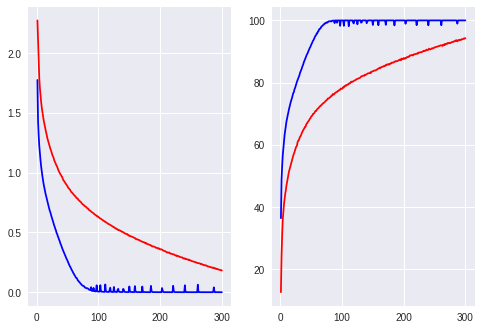

In [114]:
import matplotlib.pyplot as plt

train1_lines = [l.strip().split() for l in open("log_train_noaug.txt", "r")]
train2_lines = [l.strip().split() for l in open("log_train_aug.txt", "r")]
x =[]
train1_error= []
train1_acc =[]
train2_error= []
train2_acc =[]
for l in zip(train1_lines, train2_lines):
  x.append(int(l[0][0]) )
  train1_error.append(float(l[0][1]) )
  train1_acc.append(float(l[0][2]) )
  train2_error.append(float(l[1][1]) )
  train2_acc.append(float(l[1][2]) )
  
# 表示関連
fig=plt.figure()

ax=fig.add_subplot(121)
ax.plot(x, train1_error,color='Blue')
ax.plot(x, train2_error,color='Red')

ax=fig.add_subplot(122)
ax.plot(x, train1_acc,color='Blue')
ax.plot(x, train2_acc,color='Red')

plt.show()



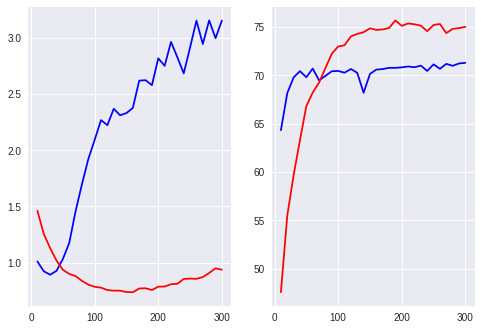

In [115]:
test1_lines = [l.strip().split() for l in open("log_test_noaug.txt", "r")]
test2_lines = [l.strip().split() for l in open("log_test_aug.txt", "r")]
x =[]
test1_error= []
test1_acc =[]
test2_error= []
test2_acc =[]
for l in zip(test1_lines, test2_lines):
  x.append(int(l[0][0]) )
  test1_error.append(float(l[0][1]) )
  test1_acc.append(float(l[0][2]) )
  test2_error.append(float(l[1][1]) )
  test2_acc.append(float(l[1][2]) )
  
# 表示関連
fig=plt.figure()

ax=fig.add_subplot(121)
ax.plot(x, test1_error,color='Blue')
ax.plot(x, test2_error,color='Red')

ax=fig.add_subplot(122)
ax.plot(x, test1_acc,color='Blue')
ax.plot(x, test2_acc,color='Red')

plt.show()

In [0]:
import tensorflow as tf
import pickle
import sys
import os
import time
import numpy as np
import glob
import cv2

def load_dataset(dirpath='cifar-10-batches-py'):
    X, y = [], []
    # take data from the data batch
    for path in glob.glob('%s/data_batch_*' % dirpath):
        with open(path, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
        # append all data and labels from the 5 data betch
        X.append(batch[b'data'])
        y.append(batch[b'labels'])
    # devide by 255 for making value 0 to 1
    X = np.concatenate(X) /np.float32(255)
    # making labels as int
    y = np.concatenate(y).astype(np.int64)
    #seperate in to RGB colors
    X = np.dstack((X[:, :1024], X[:, 1024:2048], X[:, 2048:]))
    # reshape data into 4D tensor with compatible to CNN model
    X_train = X.reshape((X.shape[0], 32, 32, 3))
    y_train = y.reshape((y.shape[0]))
        
    # load test set
    path = '%s/test_batch' % dirpath
    with open(path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    X_test = batch[b'data'] /np.float32(255)
    X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
    X_test = X_test.reshape((X_test.shape[0], 32, 32, 3))
    y_t = np.array(batch[b'labels'], dtype=np.int64)
    y_test = y_t.reshape((y_t.shape[0]))

    # normalize to zero mean and unity variance
    offset = np.mean(X_train, 0)
    scale = np.std(X_train, 0).clip(min=1)
    X_train = (X_train - offset) / scale
    X_test = (X_test - offset) / scale
    return X_train, y_train, X_test, y_test

# this function is used as divide input data and labels in mini batch(batchsize) and also used shuffle to give some randomness to CNN 
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    # shuffle is used in train the data
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Convolution neural network model
# {conv(with relu) -> max_pool -> conv(with relu) -> max_pool -> conv(with relu) -> max_pool -> dense layer -> [output(train), softmax(main predictionss)]} 
def build_model(input_val,w,b):

    conv1 = tf.nn.conv2d(input_val,w['w1'],strides = [1,1,1,1], padding = 'SAME')
    conv1 = tf.nn.bias_add(conv1,b['b1'])
    conv1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1,w['w2'],strides = [1,1,1,1], padding = 'SAME')
    conv2 = tf.nn.bias_add(conv2,b['b2'])
    conv2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv3 = tf.nn.conv2d(pool2,w['w3'],strides = [1,1,1,1], padding = 'SAME')
    conv3 = tf.nn.bias_add(conv3,b['b3'])
    conv3 = tf.nn.relu(conv3)  
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    shape = pool3.get_shape().as_list()
    dense = tf.reshape(pool3,[-1,shape[1]*shape[2]*shape[3]])
    dense1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(dense,w['w4']),b['b4']))
    
    # used for training the CNN model
    out = tf.nn.bias_add(tf.matmul(dense1,w['w5']),b['b5'])

    # used after training the CNN
    softmax = tf.nn.softmax(out)
    
#    return out
    return out,softmax

# main function where network train and predict the output on random image
def main_function(num_epochs=100):
    
    # initialize input data shape and datatype for data and labels
    x = tf.placeholder(tf.float32,[None,32,32,3])
    y = tf.placeholder(tf.int64,[None])
    
    # initialize weights for every different layers
    weights = {
        'w1': tf.Variable(tf.random_normal([5,5,3,120],stddev = 0.1)),
        'w2': tf.Variable(tf.random_normal([5,5,120,60],stddev = 0.1)),
        'w3': tf.Variable(tf.random_normal([4,4,60,30],stddev = 0.1)),
        'w4': tf.Variable(tf.random_normal([4*4*30,30],stddev = 0.1)),
        'w5': tf.Variable(tf.random_normal([30,10],stddev = 0.1))
    }

    # initialize biases for every different layers
    biases = {
        'b1': tf.Variable(tf.random_normal([120],stddev = 0.1)),
        'b2': tf.Variable(tf.random_normal([60],stddev = 0.1)),
        'b3': tf.Variable(tf.random_normal([30],stddev = 0.1)),
        'b4': tf.Variable(tf.random_normal([30],stddev = 0.1)),
        'b5': tf.Variable(tf.random_normal([10],stddev = 0.1))
    }

    # call model 
    predict,  softmax_out= build_model(x,weights,biases)
    # whole back propagetion process
    error = tf.reduce_mean( tf.losses.sparse_softmax_cross_entropy(logits = predict,labels = y))
    optm = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(error)
#    corr = tf.equal(tf.argmax(predict,1),tf.argmax(y,1))
#    accuracy = tf.reduce_mean(tf.cast(corr,tf.float32))
    
    corr = tf.equal(tf.argmax(predict, 1), y)
    accuracy = tf.reduce_mean(tf.cast(corr, tf.float32)) 
    
    # initialize tensorflow session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # load dataset 
    print("loading dataset...")
    X_train,y_train, X_test,y_test = load_dataset()
    # training will start
    print("Starting training...")
    
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        # devide data into mini batch
        for batch in iterate_minibatches(X_train, y_train, 128, shuffle=True):
            # this is update weights
            tt = sess.run(optm,feed_dict = {x: batch[0],y: batch[1]})
            # cost function
            err,acc= sess.run([error,accuracy],feed_dict = {x: batch[0],y: batch[1]})
            
            train_err += err
            train_acc += acc
            train_batches += 1
        print("Epoch: ",  epoch, " Error: ", train_err/train_batches, " Accuracy: ", train_acc/train_batches )    
        
    # testing using test dataset as per above    
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 128, shuffle=False):
        err, acc = sess.run([error,accuracy],feed_dict = {x: batch[0],y: batch[1]})# apply tensor function
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

    sess.close()

main_function()

loading dataset...
Starting training...
Epoch:  0  Error:  1.769444672877972  Accuracy:  0.32646233974358974
Epoch:  1  Error:  1.3689732319269425  Accuracy:  0.4936298076923077
Epoch:  2  Error:  1.238407427072525  Accuracy:  0.5477163461538461
Epoch:  3  Error:  1.1604523032139509  Accuracy:  0.5821514423076923
Epoch:  4  Error:  1.1072061511186453  Accuracy:  0.6032051282051282
Epoch:  5  Error:  1.0733148406713438  Accuracy:  0.614803685897436
Epoch:  6  Error:  1.0450280990356053  Accuracy:  0.6280849358974359
Epoch:  7  Error:  1.0189929687059842  Accuracy:  0.6352363782051282
Epoch:  8  Error:  0.997243180947426  Accuracy:  0.6438301282051282
Epoch:  9  Error:  0.9766303728788327  Accuracy:  0.6540665064102564
Epoch:  10  Error:  0.9616725834516379  Accuracy:  0.6582932692307693
Epoch:  11  Error:  0.9454503698226733  Accuracy:  0.6639623397435898
Epoch:  12  Error:  0.9336168417563805  Accuracy:  0.669110576923077
Epoch:  13  Error:  0.906637488420193  Accuracy:  0.677403846153

In [0]:
!ls cifar-10-batches-py



batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
